# Liesel-GAM Demo Notebook

## Setup and Imports

In [9]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import liesel_gam as gam
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.bijectors as tfb
import tensorflow_probability.substrates.jax.distributions as tfd

from smoothcon import SmoothCon

In [10]:
from scipy import stats

rng = np.random.default_rng(1)
x = rng.uniform(-2, 2, 200)

log_sigma = -1.0 + 0.3 * (
    0.5 * x + 15 * stats.norm.pdf(2 * (x - 0.2)) - stats.norm.pdf(x + 0.4)
)
mu = -x + np.pi * np.sin(np.pi * x)
y = mu + jnp.exp(log_sigma) * rng.normal(0.0, 1.0, 200)

df = pd.DataFrame({"y": y, "x": x})

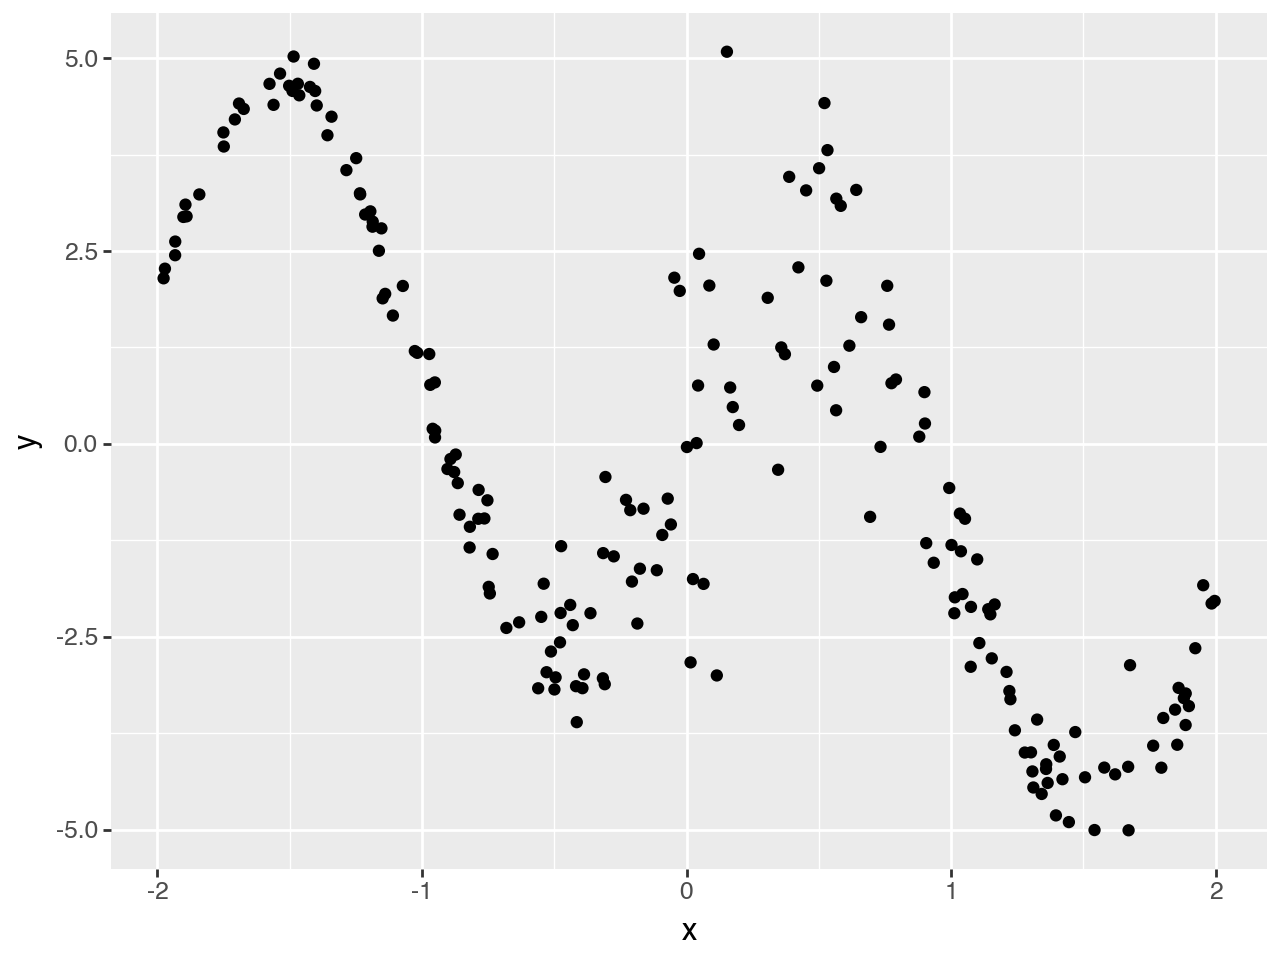

In [11]:
(p9.ggplot(df) + p9.geom_point(p9.aes("x", "y")))

## Model Definition

The `gam.AdditivePredictor()` objects are special `lsl.Var` classes. They allow users to add 
variables with the `+=` operator, and always represent the sum of all their inputs.
Thus, they conveniently represent additive predictors.

### Setup response model

In [12]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=y,
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

### Set up intercepts

In [13]:
loc += gam.Intercept(name="$\\beta_0$", inference=gs.MCMCSpec(gs.IWLSKernel))
scale += gam.Intercept(name="$\\gamma_0$", inference=gs.MCMCSpec(gs.IWLSKernel))

### Set up basis an penalty matrices

Here, we pull the basis matrix and penalty from mgcv. Note that, using the 
`SmoothCon` class, you only need to execute Python code. No manual R call and 
convesion to Python objects necessary.

In [14]:
smooth_x = SmoothCon(
    # this string is the R code you *would* call in mgcv for this term
    spec="s(x, bs='ps', k=20, m=c(3,2))",
    data=df,
)

x_basis = gam.Basis(smooth_x.basis, name="B(x)")
penalty = smooth_x.penalty

### Initialize inverse smoothing parameters

Here, we initialize the inverse smoothing parameters. Setting it up like this allows us
to freely exchange their priors and/or their inference information, if we want or need
to.

In [15]:
m_x_tau2 = lsl.Var.new_param(
    value=1.0,
    distribution=lsl.Dist(tfd.InverseGamma, concentration=2.0, scale=0.5),
    name="$\\tau^2_m$",
)
m_x_tau = lsl.Var.new_calc(jnp.sqrt, m_x_tau2, name="$\\tau_m$")
m_x_tau2_log = m_x_tau2.transform(
    tfb.Exp(),
    name="$\\log \\tau^2_m$",  # New in liesel v0.4.0
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
)


s_x_tau2 = lsl.Var.new_param(
    1.0, lsl.Dist(tfd.InverseGamma, concentration=2.0, scale=0.5), name="$\\tau^2_s$"
)
s_x_tau = lsl.Var.new_calc(jnp.sqrt, s_x_tau2, name="$\\tau_s$")
s_x_tau2_log = s_x_tau2.transform(
    tfb.Exp(),
    name="$\\log \\tau^2_s$",  # New in liesel v0.4.0
    inference=gs.MCMCSpec(gs.NUTSKernel),  # New in liesel v0.4.0
)

### Initialize smooth terms

The `gam.SmoothTerm` can be used to represent isotropic smooths. It is a `lsl.Var` that
will automatically initialize a fitting coefficient variabel with a 
potentially singular multivariate normal prior given the penalty matrix.

In [16]:
loc += gam.SmoothTerm(
    basis=x_basis,
    penalty=penalty,
    scale=m_x_tau,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="m(x)",
    coef_name="$\\beta$",  # I'm using LaTeX math syntax for pretty rendering in plots
)

scale += gam.SmoothTerm(
    basis=x_basis,
    penalty=penalty,
    scale=s_x_tau,
    inference=gs.MCMCSpec(gs.IWLSKernel),  # New in liesel v0.4.0
    name="s(x)",
    coef_name="$\\gamma$",
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="").value
liesel.model.model - INFO - Converted dtype of Value(name="B(x)_value").value
liesel.model.model - INFO - Converted dtype of Value(name="").value


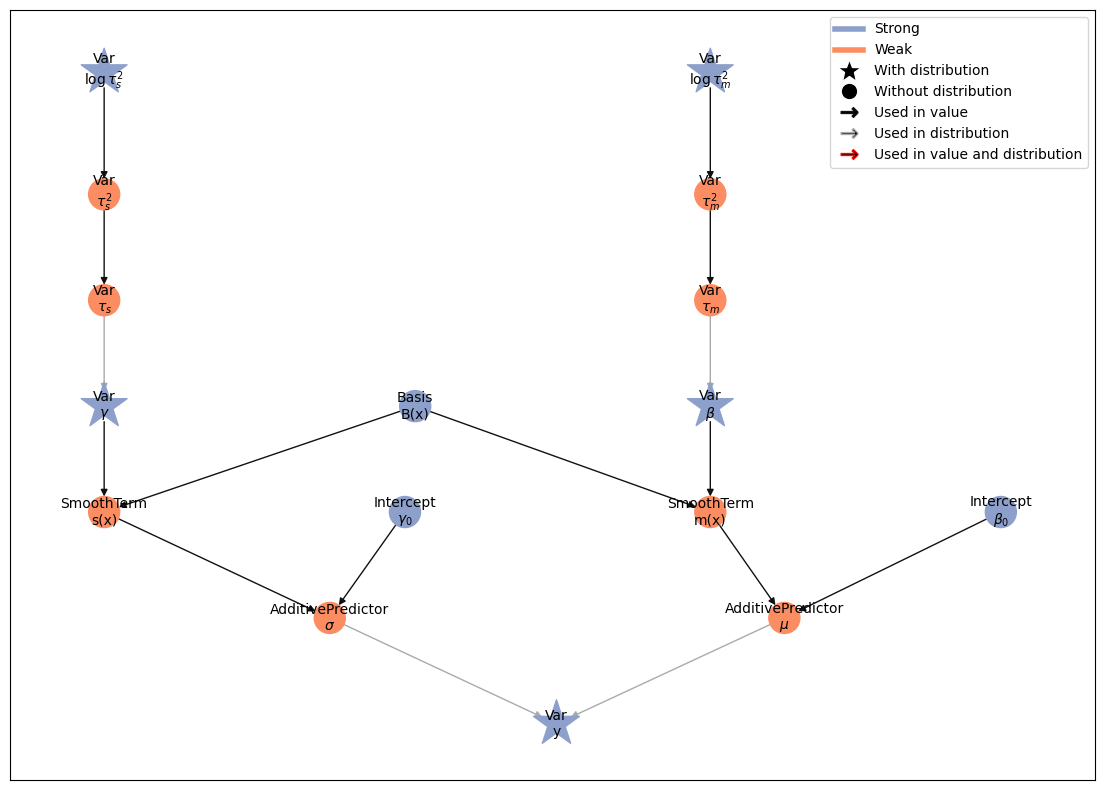

In [17]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [18]:
eb = gs.LieselMCMC(model).get_engine_builder(
    seed=1, num_chains=4
)  # New in liesel v0.4.0

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\gamma$', '$\\log \\tau^2_s$', '$\\gamma_0$', '$\\beta$', '$\\log \\tau^2_m$', '$\\beta_0$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:06<00:00,  2.37chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 1, 0, 0, 0 / 400 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_01: 2, 5, 2, 5 / 400 transitions
liesel.goose.engine - WARNING - Errors per chain for kernel_04: 3, 5, 4, 2 / 400 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 102.82chunk/s]
liese

### MCMC summary

In [19]:
summary = gs.Summary(results)
summary

Parameter summary:

                          kernel      mean        sd    q_0.05     q_0.5  \
parameter       index                                                      
$\beta$         (0,)   kernel_03  0.279992  0.453687 -0.436882  0.270693   
                (1,)   kernel_03  0.021829  0.408386 -0.642967  0.010367   
                (2,)   kernel_03  0.471863  0.435877 -0.216215  0.453807   
                (3,)   kernel_03  0.197462  0.407710 -0.463259  0.198118   
                (4,)   kernel_03  0.159790  0.369885 -0.439400  0.156233   
                (5,)   kernel_03  0.154997  0.350418 -0.434559  0.145048   
                (6,)   kernel_03 -0.022401  0.338132 -0.576093 -0.020855   
                (7,)   kernel_03  0.072740  0.313281 -0.427734  0.071065   
                (8,)   kernel_03  0.069489  0.303562 -0.410608  0.062454   
                (9,)   kernel_03  0.114388  0.263046 -0.312246  0.111400   
                (10,)  kernel_03  0.113167  0.251461 -0.311868  0.121413   
                (11,)  kernel_03 -0.142110  0.210886 -0.488177 -0.142874   
                (12,)  kernel_03  0.291536  0.187251 -0.016874  0.291661   
                (13,)  kernel_03 -0.028495  0.145978 -0.267691 -0.028593   
                (14,)  kernel_03  1.372296  0.112513  1.188982  1.370452   
                (15,)  kernel_03 -0.050962  0.072692 -0.172157 -0.050643   
                (16,)  kernel_03  0.127904  0.042051  0.060453  0.127748   
                (17,)  kernel_03  0.016994  0.017081 -0.010656  0.017014   
                (18,)  kernel_03 -0.303129  0.065128 -0.410896 -0.303739   
$\beta_0$       ()     kernel_05 -0.315505  0.061940 -0.416373 -0.315638   
$\gamma$        (0,)   kernel_00  0.103860  0.323734 -0.403743  0.097865   
                (1,)   kernel_00  0.093991  0.324368 -0.422830  0.092494   
                (2,)   kernel_00 -0.000527  0.318525 -0.527866  0.006734   
                (3,)   kernel_00  0.034159  0.308225 -0.473917  0.038830   
                (4,)   kernel_00 -0.143159  0.300668 -0.659947 -0.136859   
                (5,)   kernel_00  0.034138  0.282779 -0.431454  0.036304   
                (6,)   kernel_00 -0.188915  0.273054 -0.642352 -0.188774   
                (7,)   kernel_00  0.213291  0.247900 -0.175716  0.210328   
                (8,)   kernel_00  0.117064  0.233485 -0.265654  0.120259   
                (9,)   kernel_00 -0.007779  0.213061 -0.357079 -0.007164   
                (10,)  kernel_00  0.034501  0.204760 -0.300436  0.034090   
                (11,)  kernel_00  0.052803  0.195077 -0.267573  0.049967   
                (12,)  kernel_00  0.193525  0.177352 -0.096101  0.193674   
                (13,)  kernel_00 -0.154734  0.151747 -0.408843 -0.153421   
                (14,)  kernel_00  0.015351  0.117287 -0.176041  0.014417   
                (15,)  kernel_00 -0.054553  0.082594 -0.190641 -0.053540   
                (16,)  kernel_00 -0.025162  0.047563 -0.101553 -0.025301   
                (17,)  kernel_00 -0.051591  0.020582 -0.084919 -0.051679   
                (18,)  kernel_00  0.105171  0.076629 -0.018543  0.104798   
$\gamma_0$      ()     kernel_02 -0.638345  0.053794 -0.725361 -0.639065   
$\log \tau^2_m$ ()     kernel_04 -1.468591  0.379974 -2.051733 -1.486295   
$\log \tau^2_s$ ()     kernel_01 -2.304079  0.412876 -2.932648 -2.334101   

                         q_0.95  sample_size     ess_bulk     ess_tail  \
parameter       index                                                    
$\beta$         (0,)   1.042386         4000  3549.915315  3198.868263   
                (1,)   0.708362         4000  3270.264213  3774.985325   
                (2,)   1.199234         4000  3482.087642  3735.724896   
                (3,)   0.871978         4000  2932.855363  3657.746472   
                (4,)   0.766723         4000  3593.353943  3882.412161   
                (5,)   0.738927         4000  3312.176065  4039.312331   
                (6,)   0.516573         400

### MCMC trace plots

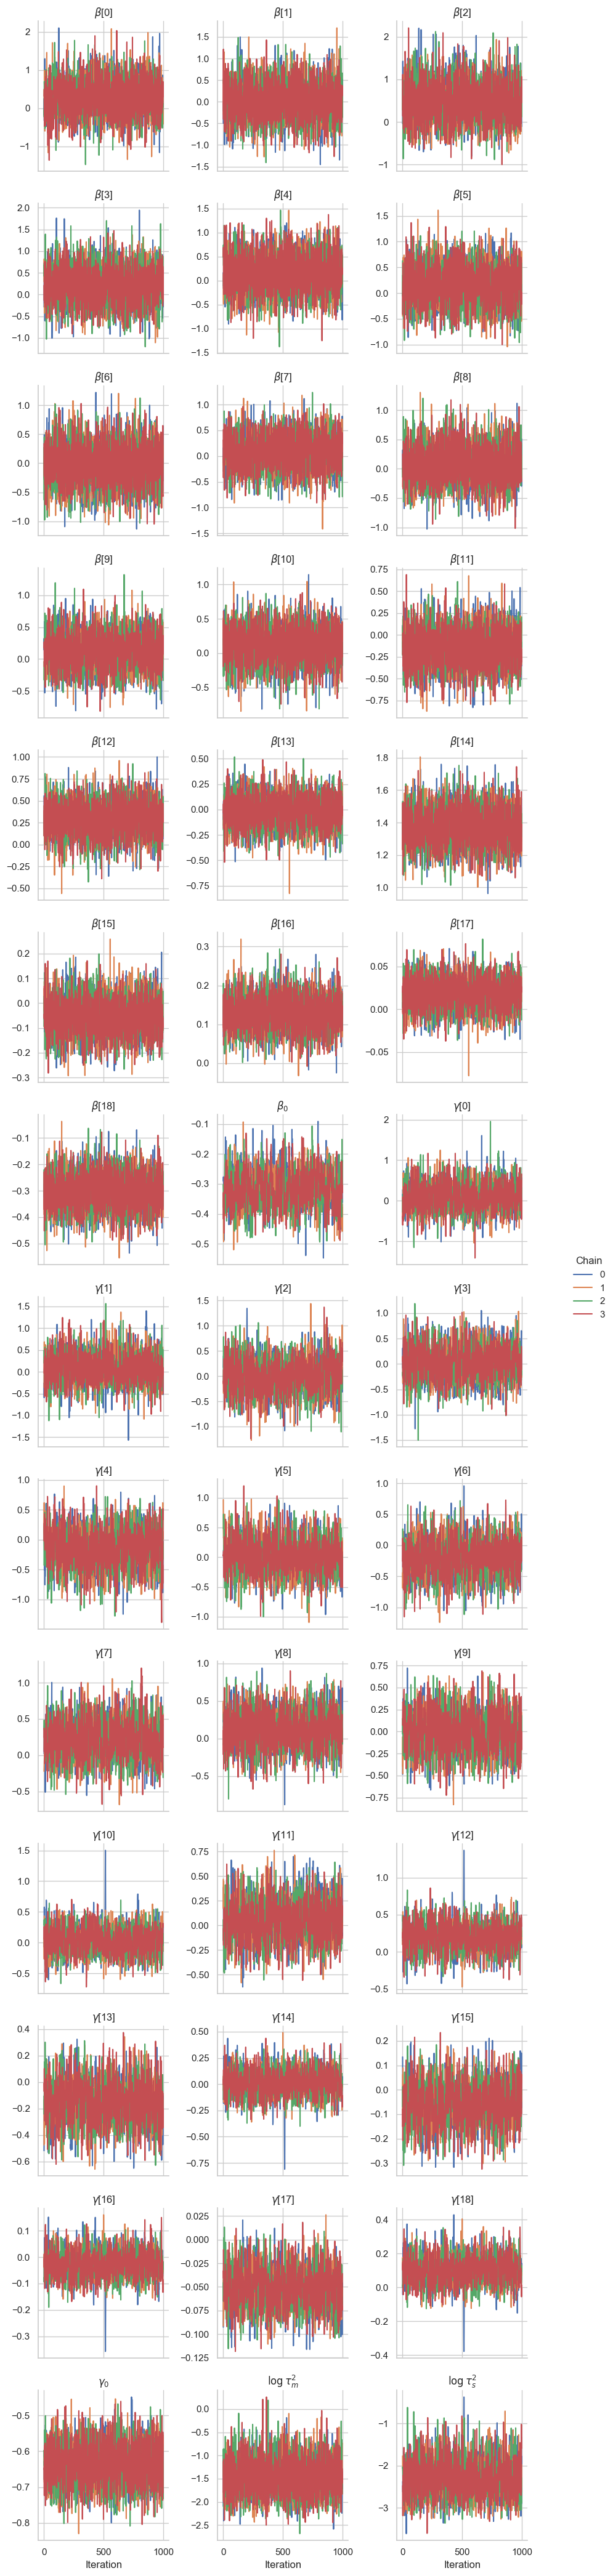

In [20]:
gs.plot_trace(results)

## Predictions

In [21]:
samples = results.get_posterior_samples()

### Evaluate basis matrix for new x values

We use the `SmoothCon` oject initialized above. This will internally call `mgcv`
to evaluate the basis matrix at the new x values, applying all the right reparameterizations 
automatically.

In [22]:
x_grid = jnp.linspace(x.min(), x.max(), 200)
B_x_grid = smooth_x.predict(data={"x": x_grid})

### Predict variables at new x values

In [23]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["m(x)", "s(x)", "$\\mu$", "$\\sigma$"],
    newdata={"B(x)": B_x_grid},
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0
predictions_summary["x"] = np.tile(x_grid, len(predictions))

In [24]:
predictions_summary.head()

,variable,var_fqn,var_index,sample_size,mean,var,sd,rhat,ess_bulk,ess_tail,mcse_mean,mcse_sd,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high,x
0,$\mu$,$\mu$[0],"(0,)",4000,2.189567,0.004425,0.066522,1.000234,3483.136984,3223.005044,0.001129,0.001144,2.086166,2.185807,2.303137,2.080752,2.294153,-1.976702
1,$\mu$,$\mu$[1],"(1,)",4000,2.376000,0.002623,0.051214,1.000652,3542.522106,3204.673034,0.000861,0.000897,2.294166,2.374349,2.462488,2.284787,2.450209,-1.956738
2,$\mu$,$\mu$[2],"(2,)",4000,2.557868,0.001867,0.043210,1.000464,3516.460155,3738.178693,0.000725,0.000724,2.489310,2.556995,2.627750,2.491533,2.629263,-1.936774
3,$\mu$,$\mu$[3],"(3,)",4000,2.734804,0.001754,0.041883,1.000501,3509.977467,3570.492123,0.000704,0.000628,2.667417,2.734810,2.803586,2.666064,2.801475,-1.916810
4,$\mu$,$\mu$[4],"(4,)",4000,2.906451,0.001990,0.044605,0.999947,3416.563581,3840.701609,0.000762,0.000622,2.831428,2.907447,2.978791,2.834325,2.981398,-1.896846


### Plot fitted functions

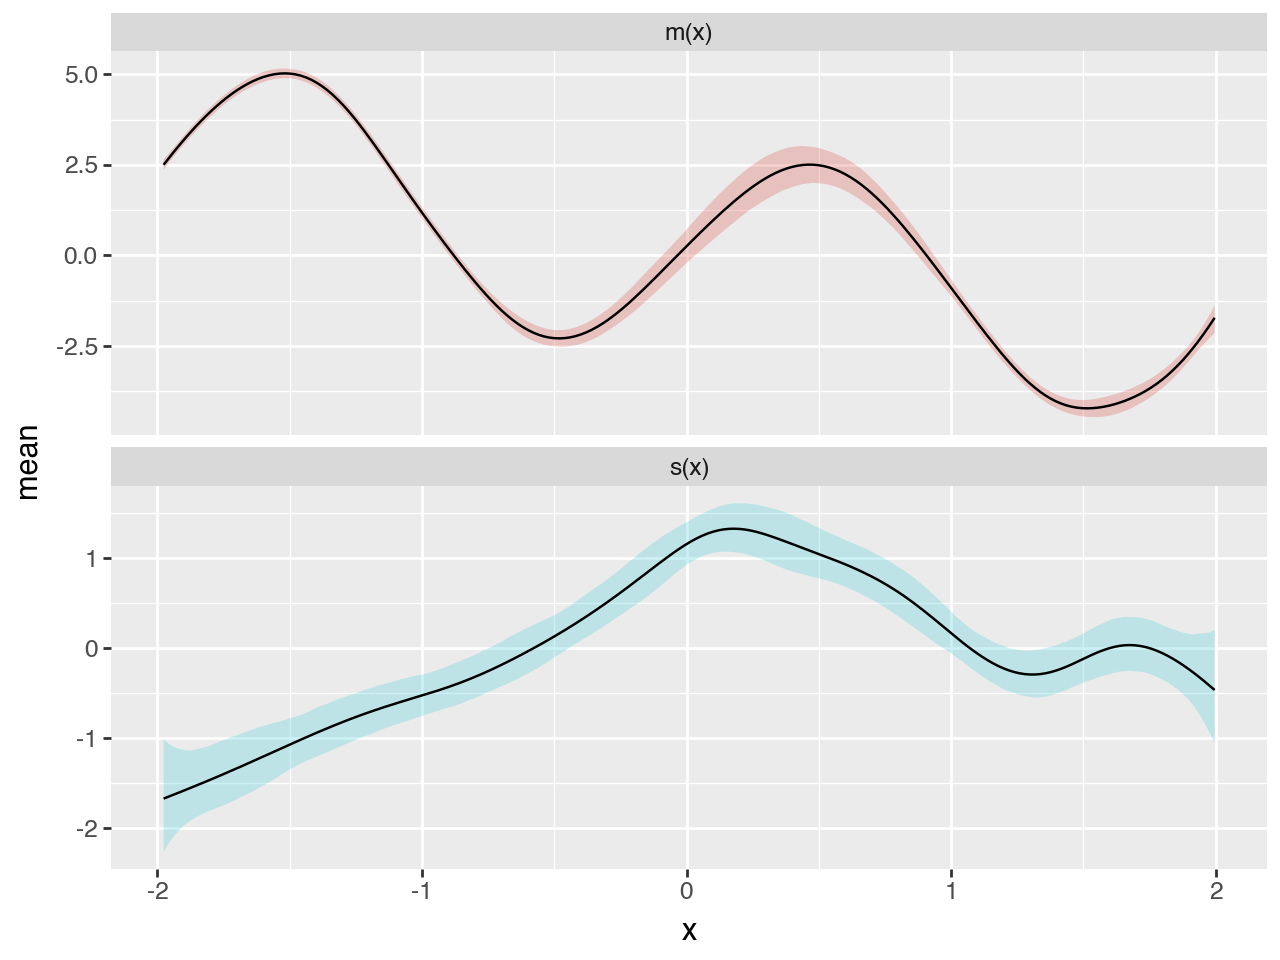

In [25]:
select = predictions_summary["variable"].isin(["s(x)", "m(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot parameters as functions of covariate

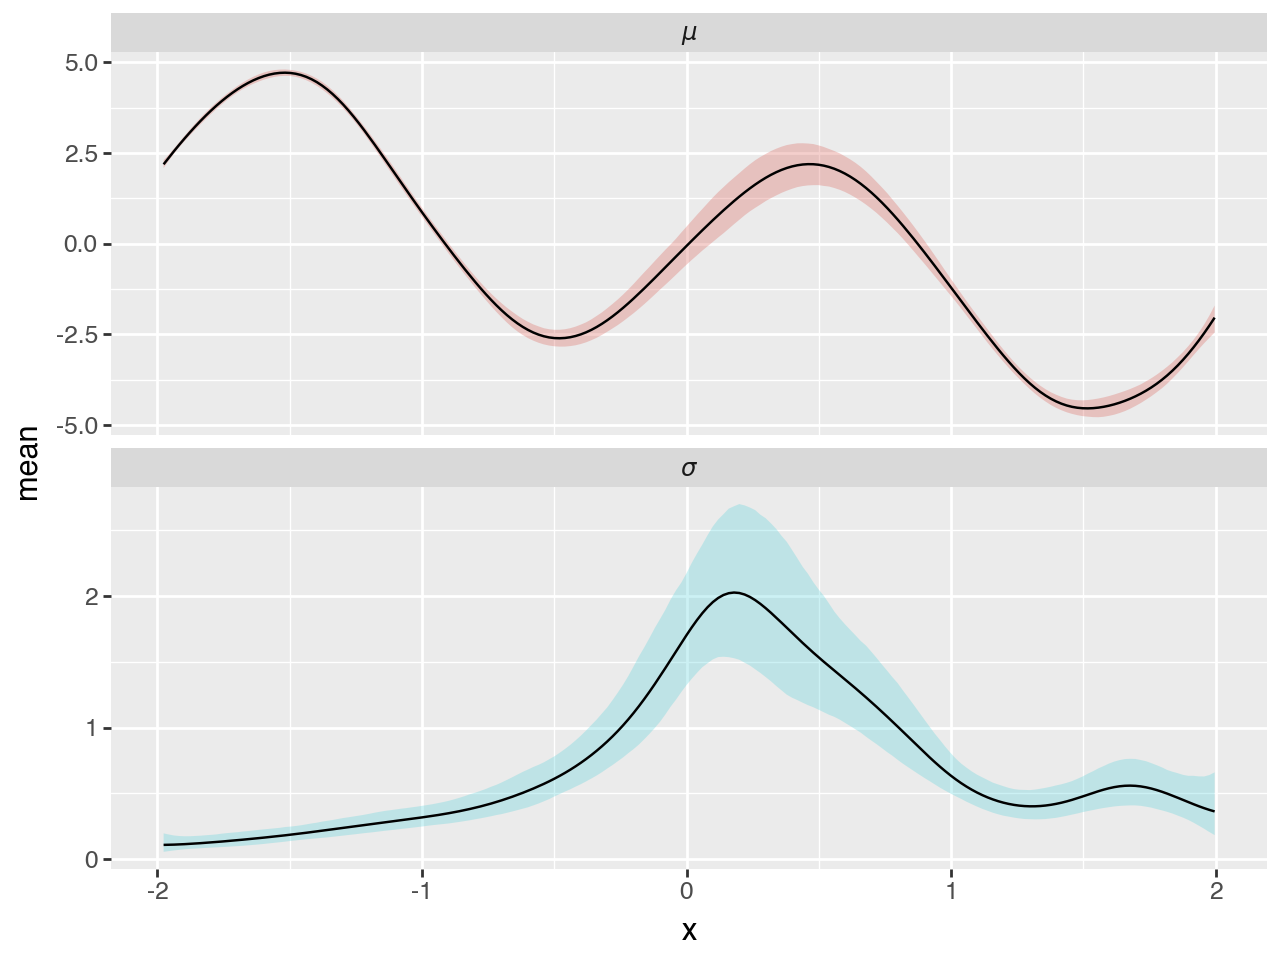

In [26]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

### Plot mean function with data

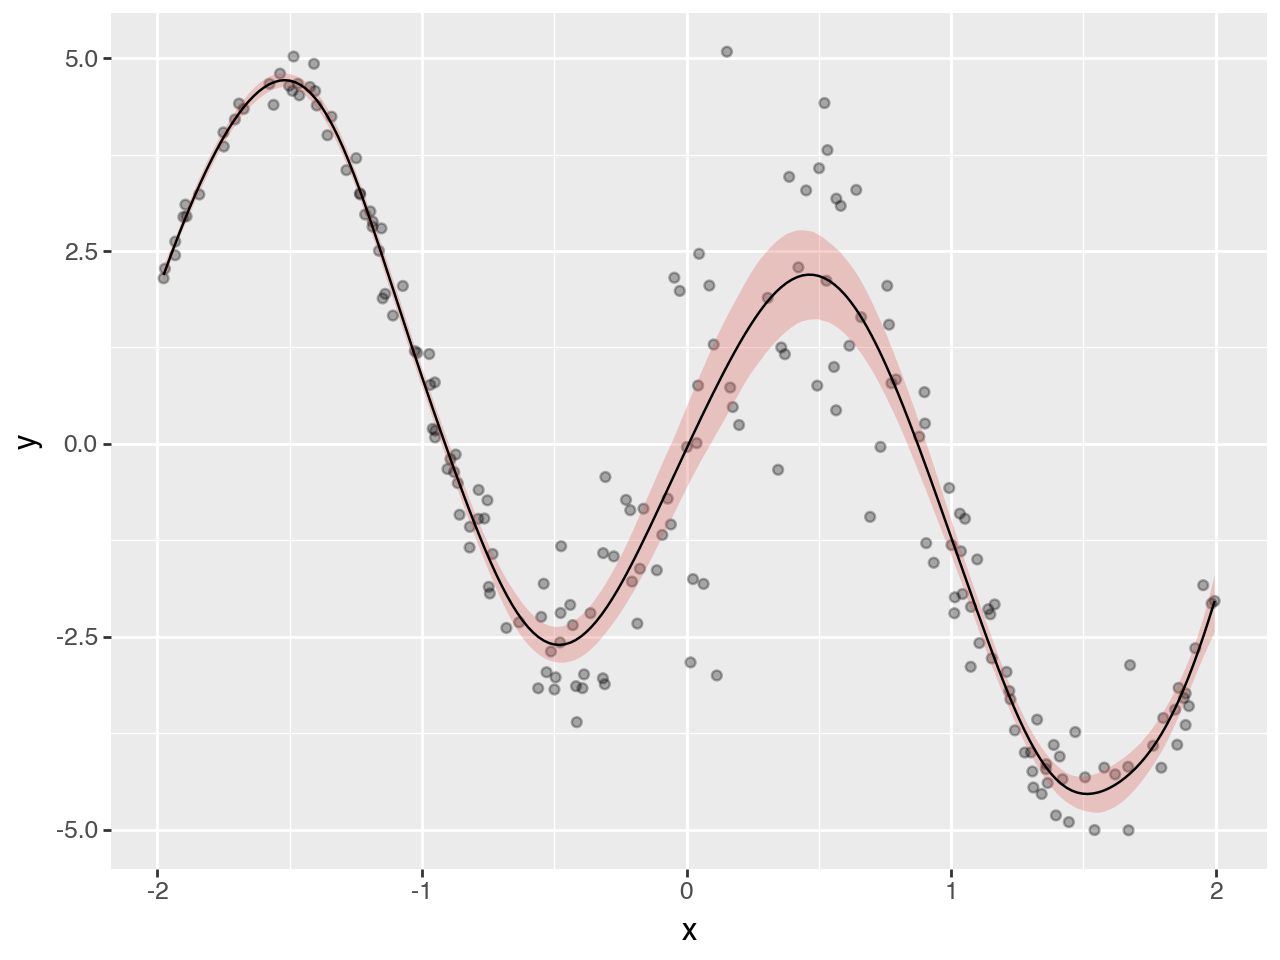

In [27]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.guides(fill="none")
)

### Plot average posterior predictive distribution

In [28]:
select = predictions_summary["variable"].isin(["$\\mu$", "$\\sigma$"])
mu_sigma_df = (
    predictions_summary[select][["variable", "mean", "x"]]
    .pivot(index="x", columns=["variable"], values="mean")
    .reset_index()
)

mu_sigma_df["low"] = mu_sigma_df["$\\mu$"] - mu_sigma_df["$\\sigma$"]
mu_sigma_df["high"] = mu_sigma_df["$\\mu$"] + mu_sigma_df["$\\sigma$"]
mu_sigma_df

variable,x,$\mu$,$\sigma$,low,high
0,-1.976702,2.189567,0.107694,2.081873,2.297261
1,-1.956738,2.376000,0.108460,2.267540,2.484461
2,-1.936774,2.557868,0.109684,2.448183,2.667552
3,-1.916810,2.734804,0.111304,2.623499,2.846108
4,-1.896846,2.906451,0.113266,2.793186,3.019717
...,...,...,...,...,...
195,1.916248,-2.855819,0.417213,-3.273033,-2.438606
196,1.936212,-2.666357,0.401716,-3.068073,-2.264642
197,1.956176,-2.466161,0.387179,-2.853340,-2.078981
198,1.976140,-2.255824,0.373886,-2.629710,-1.881938


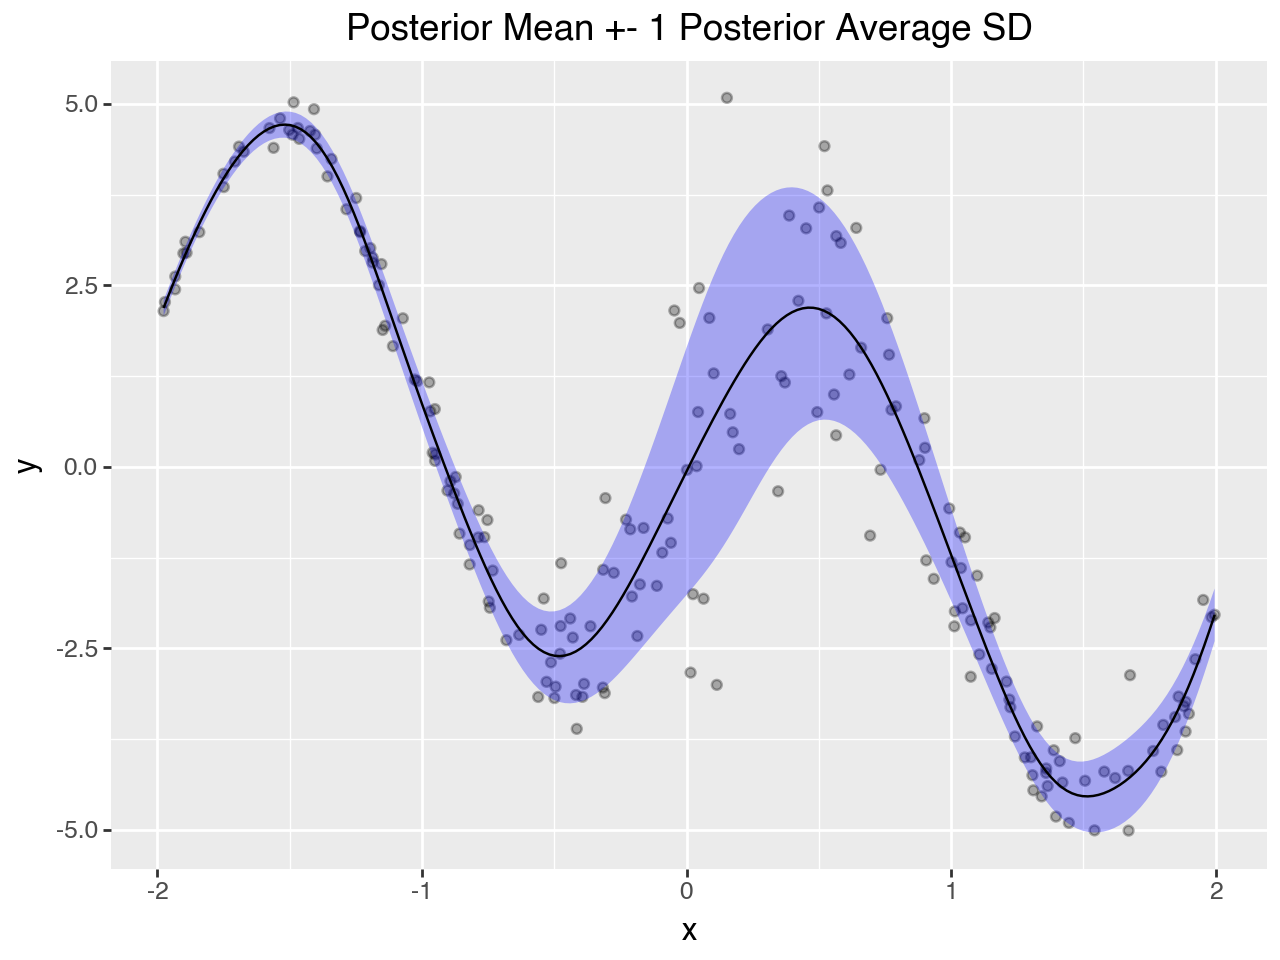

In [29]:
(
    p9.ggplot()
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="low", ymax="high"),
        alpha=0.3,
        fill="blue",
        data=mu_sigma_df,
    )
    + p9.geom_line(p9.aes("x", "$\\mu$"), data=mu_sigma_df)
    + p9.labs(title="Posterior Mean +- 1 Posterior Average SD")
    + p9.guides(fill="none")
)

## Posterior Predictive Checks

### Draw posterior predictive samples

In [30]:
ppsamples = model.sample(  # new in liesel v0.4.0
    shape=(3,), seed=jax.random.key(1), posterior_samples=samples
)

ppsamples["y"].shape

(3, 4, 1000, 200)

In [31]:
# can be reshaped to concatenate the first two axes
_ = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])

### Summarize posterior predictive samples

In [32]:
ppsamples = model.sample(
    shape=(),  # just draw 1 value for each posterior sample
    seed=jax.random.key(1),
    posterior_samples=samples,
)

# summarise ppsamples
ppsamples_summary = gs.SamplesSummary(ppsamples).to_dataframe().reset_index()

# add covariate to df
ppsamples_summary["x"] = df["x"].to_numpy()

### Plot posterior predictive summary

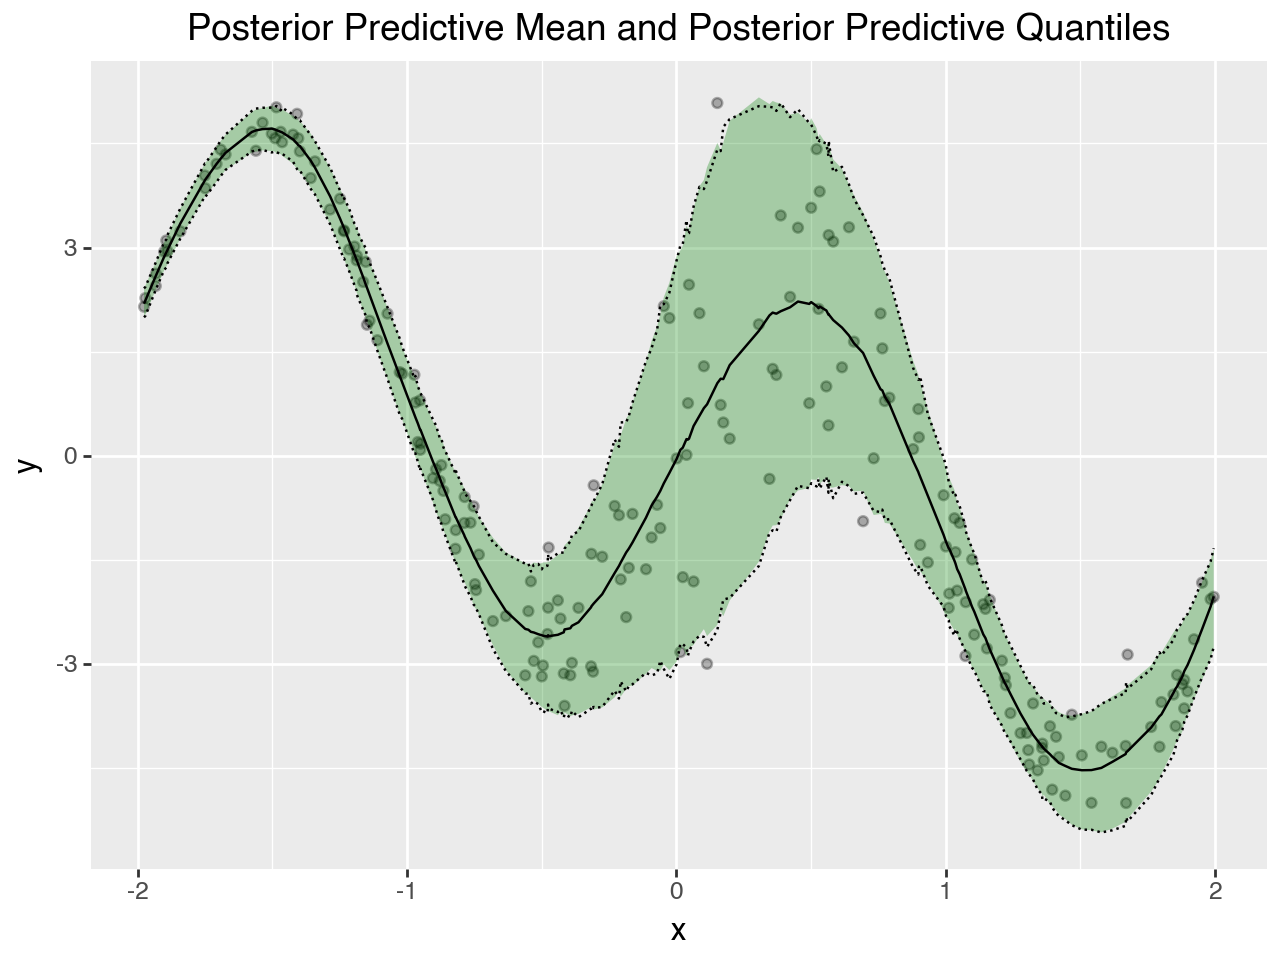

In [33]:
(
    p9.ggplot(ppsamples_summary)
    + p9.geom_point(p9.aes("x", "y"), data=df, alpha=0.3)
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
    )
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted")
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.labs(title="Posterior Predictive Mean and Posterior Predictive Quantiles")
    + p9.guides(fill="none")
)

### Plot posterior predictive samples

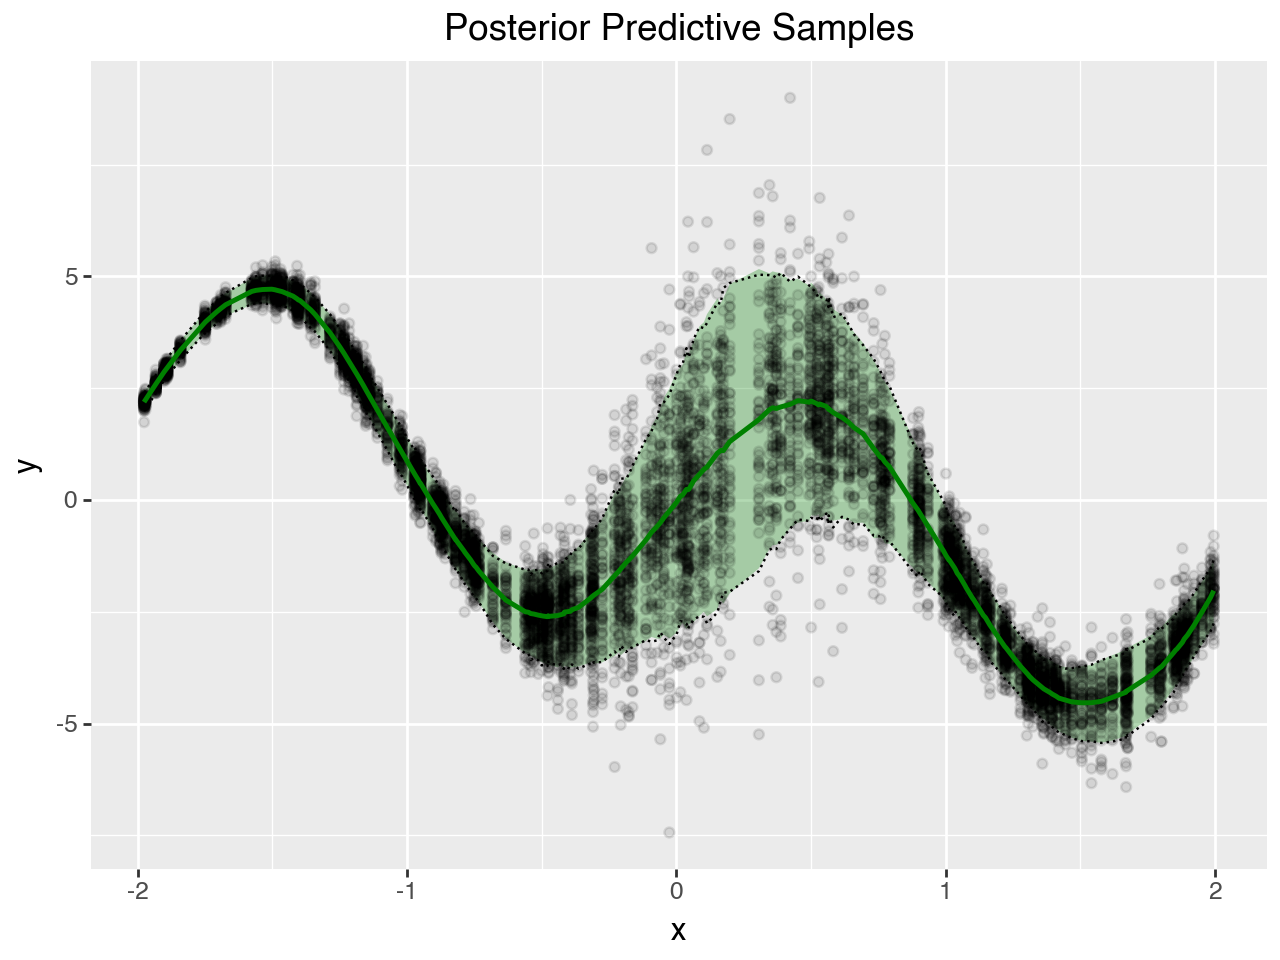

In [34]:
ppsamples_reshaped = ppsamples["y"].reshape(-1, *ppsamples["y"].shape[2:])
ppsamples_df = pd.DataFrame(ppsamples_reshaped.T)
ppsamples_df["x"] = df["x"].to_numpy()
ppsamples_df = ppsamples_df.melt(id_vars=["x"], value_name="y", var_name="sample")
ppsamples_df[ppsamples_df["sample"].isin(range(5))]


nsamples = 50


(
    p9.ggplot(ppsamples_df[ppsamples_df["sample"].isin(range(nsamples))])
    + p9.labs(title="Posterior Predictive Samples")
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95"),
        alpha=0.3,
        fill="green",
        data=ppsamples_summary,
    )
    + p9.geom_point(p9.aes("x", "y"), alpha=0.1)
    + p9.geom_line(p9.aes("x", "hdi_low"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "hdi_high"), linetype="dotted", data=ppsamples_summary)
    + p9.geom_line(p9.aes("x", "mean"), color="green", size=1, data=ppsamples_summary)
)